## 5. 練習問題

1. 異なるゲート（$\text{CNOT}$, 制御$S$, 制御$T^\dagger$）で上記の実験を試してください。どのような結果が期待できますか？ どのような結果が得られますか？

2. 制御$Y$ゲートを使って実験してみてください。正しい結果が得られますか？ （ヒント：$|\psi\rangle$ が$Y$の固有状態であることを確認してください！）



必要な初期設定を行う。

In [2]:
# 初期化
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskitをインポート
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# プロットツールをインポート
from qiskit.visualization import plot_histogram

IBMQ.load_account()
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
#print(provider.backends())
lima = provider.get_backend('ibmq_lima')



逆QFTを行うコード（テキストどおり）。

In [3]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)


以下、各問題で指定されたゲートに応じて、固有状態の設定を行う部分と制御ユニタリ―演算を実行する部分を適切に変えればよい。

1-1. CNOT

CNOTは制御Xゲートである。Xゲートの固有ベクトルは $|+\rangle$ および $|-\rangle$ 。ここでは $|-\rangle$ を使用する。

$X = 
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
\end{bmatrix}
$
について、$|-\rangle = 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
-1 \\
\end{bmatrix}
$ に対する固有値は、下記の計算より $-1$ であり、したがって $\theta = \frac{1}{2}$ が期待される。

$$X|-\rangle = 
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
\end{bmatrix}
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
-1 \\
\end{bmatrix}
= 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
-1 \\
1 \\
\end{bmatrix}
= -|-\rangle
= e^{2\pi i\cdot \frac{1}{2} }|-\rangle
$$




$|-\rangle$ は、XゲートとHゲートによって構成できる。

制御ユニタリ―演算はCXゲートによって構成できる。

したがって

In [4]:
qpe = QuantumCircuit(4, 3)
################################
# ユニタリ―演算子の固有状態を設定
################################
#Xゲートの場合：固有ベクトルとして|->を使用
qpe.x(3)
qpe.h(3)

for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        ################################
        # 制御ユニタリ―演算を実行
        ################################
        #Xゲートの場合
        qpe.cx(counting_qubit, 3); # C-X
        
    repetitions *= 2

qpe.barrier()

# 逆QFTを適用
qft_dagger(qpe, 3)

# 測定
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

#qpe.draw()

シミュレータでの実行結果は次の通り。

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


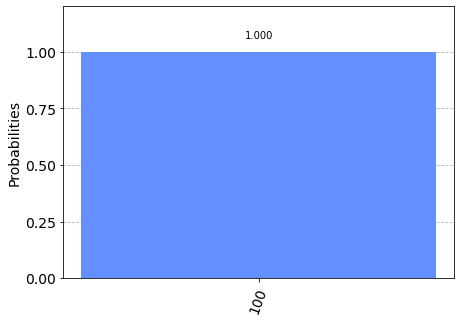

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

$\theta = \frac{100_2}{2^3} = \frac{4}{8} = \frac{1}{2}$ が得られた。

実機での実行結果は次の通り。

Job Status: job has successfully run


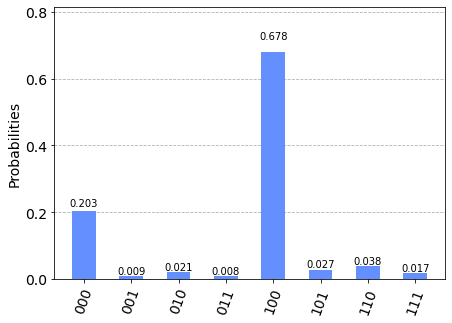

In [6]:
# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, lima, optimization_level=3)
job = lima.run(t_qpe, shots=shots)
job_monitor(job)

# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

1-2. 制御S

Sゲートの固有ベクトルは $|0\rangle$ および $|1\rangle$ 。ここでは $|1\rangle$ を使用する。


$S = 
\begin{bmatrix}
1 & 0 \\
0 & e^{\frac{\pi}{2}i} \\
\end{bmatrix}
$
について、$|1\rangle = 
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}
$ に対する固有値は、下記の計算より $e^{\frac{\pi}{2}i} (= i)$ であり、したがって $\theta = \frac{1}{4}$ が期待される。

$$S|1\rangle = 
\begin{bmatrix}
1 & 0 \\
0 & e^{\frac{\pi}{2}i} \\
\end{bmatrix}
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}
= 
\begin{bmatrix}
0 \\
e^{\frac{\pi}{2}i} \\
\end{bmatrix}
= e^{\frac{\pi}{2}i}|1\rangle
= e^{2\pi i\cdot \frac{1}{4} }|1\rangle
$$




$|1\rangle$ は、Xゲートによって構成できる。

制御ユニタリ―演算は、$\pi / 2$ 回転の制御Pゲートによって構成できる。

1-1と同様に、コード・シミュレータおよび実機での結果を以下に示す。

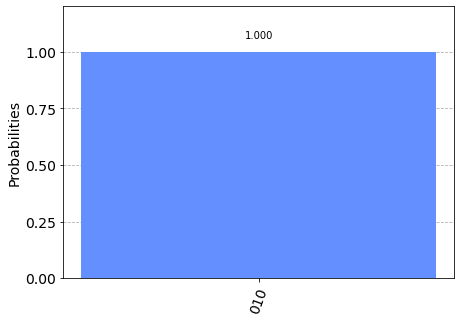

In [7]:
qpe = QuantumCircuit(4, 3)
################################
# ユニタリ―演算子の固有状態を設定
################################
#Sゲートの場合：固有ベクトルとして|1>を使用
qpe.x(3)

for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        ################################
        # 制御ユニタリ―演算を実行
        ################################
        #Sゲート（π/2回転のPゲート）の場合
        qpe.cp(math.pi/2, counting_qubit, 3); # C-S
        
    repetitions *= 2

qpe.barrier()

# 逆QFTを適用
qft_dagger(qpe, 3)

# 測定
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

#qpe.draw()
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

$\theta = \frac{010_2}{2^3} = \frac{2}{8} = \frac{1}{4}$ が得られた。

実機での実行結果は次の通り。

Job Status: job has successfully run


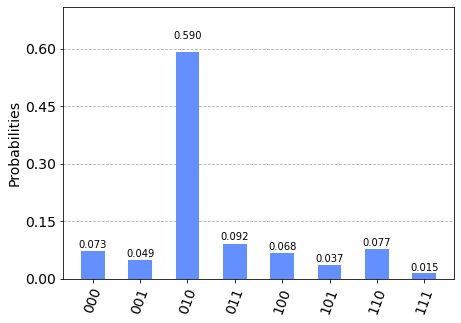

In [8]:
# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, lima, optimization_level=3)
job = lima.run(t_qpe, shots=shots)
job_monitor(job)

# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

1-3. 制御T$^\dagger$

T$^\dagger$ ゲートの固有ベクトルは $|0\rangle$ および $|1\rangle$ 。ここでは $|1\rangle$ を使用する。


$T^\dagger = 
\begin{bmatrix}
1 & 0 \\
0 & e^{-\frac{\pi}{4}i} \\
\end{bmatrix}
$
について、$|1\rangle = 
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}
$ に対する固有値は、下記の計算より $e^{-\frac{\pi}{4}i}$ であり、したがって $\theta = \frac{7}{8}$ が期待される。

$$T^\dagger|1\rangle = 
\begin{bmatrix}
1 & 0 \\
0 & e^{-\frac{\pi}{4}i} \\
\end{bmatrix}
\begin{bmatrix}
0 \\
1 \\
\end{bmatrix}
= 
\begin{bmatrix}
0 \\
e^{-\frac{\pi}{4}i} \\
\end{bmatrix}
= e^{-\frac{\pi}{4}i}|1\rangle
= e^{2\pi i\cdot (-\frac{1}{8}) }|1\rangle
= e^{2\pi i\cdot \frac{7}{8} }|1\rangle
$$






$|1\rangle$ は、Xゲートによって構成できる。

制御ユニタリ―演算は、$-\pi /4$ 回転の制御Pゲートによって構成できる。

1-1と同様に、コード・シミュレータおよび実機での結果を以下に示す。

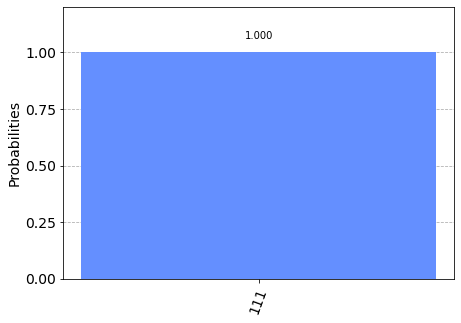

In [9]:
qpe = QuantumCircuit(4, 3)
################################
# ユニタリ―演算子の固有状態を設定
################################
#Tdagゲートの場合：固有ベクトルとして|1>を使用
qpe.x(3)

for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        ################################
        # 制御ユニタリ―演算を実行
        ################################
        #Tdagゲート（-π/4回転のPゲート）の場合
        qpe.cp(-math.pi/4, counting_qubit, 3); # C-Tdag
        
    repetitions *= 2

qpe.barrier()

# 逆QFTを適用
qft_dagger(qpe, 3)

# 測定
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

#qpe.draw()
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

$\theta = \frac{111_2}{2^3} = \frac{7}{8}$ が得られた。

実機での実行結果は次の通り。

Job Status: job has successfully run


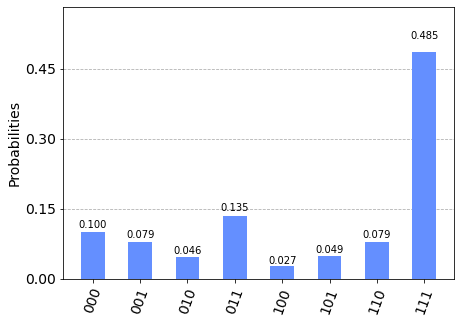

In [10]:
# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, lima, optimization_level=3)
job = lima.run(t_qpe, shots=shots)
job_monitor(job)

# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

2. 制御Y

Yゲートの固有ベクトルは $|i\rangle$ および $|i-\rangle$ 。ここでは $|i-\rangle$ を使用する。



$Y = 
\begin{bmatrix}
0 & -i \\
i & 0 \\
\end{bmatrix}
$
について、$|i-\rangle = 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
-i \\
\end{bmatrix}
$ に対する固有値は、下記の計算より $-1$ であり、したがって $\theta = \frac{1}{2}$ が期待される。

$$Y|i-\rangle = 
\begin{bmatrix}
0 & -i \\
i & 0 \\
\end{bmatrix}
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
-i \\
\end{bmatrix}
= 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
-1 \\
i \\
\end{bmatrix}
= -|i-\rangle
= e^{2\pi i\cdot \frac{1}{2} }|i-\rangle
$$





$|i-\rangle$ は、HゲートおよびSdgゲートによって構成できる。

制御ユニタリ―演算は、制御Yゲートによって構成できる。

1-1と同様に、コード・シミュレータおよび実機での結果を以下に示す。

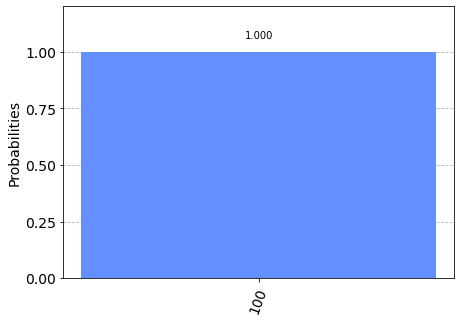

In [11]:
qpe = QuantumCircuit(4, 3)
################################
# ユニタリ―演算子の固有状態を設定
################################
#Yゲートの場合：固有ベクトルとして|i->を使用
qpe.h(3)
qpe.sdg(3)

for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        ################################
        # 制御ユニタリ―演算を実行
        ################################
        #Yゲートの場合
        qpe.cy(counting_qubit, 3); # C-Y
        
    repetitions *= 2

qpe.barrier()

# 逆QFTを適用
qft_dagger(qpe, 3)

# 測定
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

#qpe.draw()
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

$\theta = \frac{100_2}{2^3} = \frac{4}{8} = \frac{1}{2}$ が得られた。

実機での実行結果は次の通り。

Job Status: job has successfully run


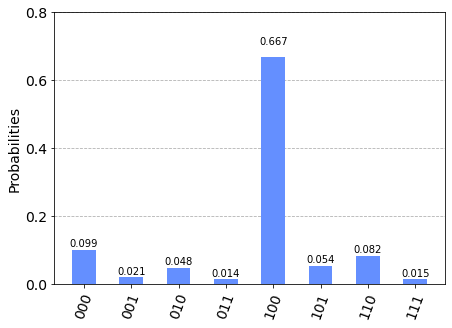

In [12]:
# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, lima, optimization_level=3)
job = lima.run(t_qpe, shots=shots)
job_monitor(job)

# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)